<a href="https://colab.research.google.com/github/prasansree/BusBookingApp/blob/main/OrderPredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Data:
                                 Id  Status                 StartDateTime  \
0  6220A6103ADFBE45BB6AD7B9068632EE       2  2/2/2026 11:27:00.0000000 AM   
1  013C4F65347C64498B07750F81300CC6       3   2/2/2026 2:12:00.0000000 PM   
2  FC5A488305177B45B553DCD271B47682       3   2/2/2026 2:15:00.0000000 PM   
3  48E5D07D19B50F48B6C143C097291883       2  2/2/2026 10:15:00.0000000 AM   
4  4ECECC7E4A9CD244BEBCCA80B7773DAC       2   2/2/2026 4:30:00.0000000 PM   

               DispatchDateTime         Description  PackedQuantity  \
0   2/2/2026 1:27:00.0000000 PM  363600001548092142               0   
1   2/2/2026 4:12:00.0000000 PM  581100001548092157               0   
2   2/2/2026 4:15:00.0000000 PM  583900001548092160               0   
3  2/2/2026 12:15:00.0000000 PM  301500001548092081              98   
4   2/2/2026 6:30:00.0000000 PM  304600001548092094              64   

   OrderedQuantity  ShortenedQuantity  OrderlineCount  PackageCount  Version  
0               

/tmp/ipython-input-3639902737.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DispatchDateTime'] = pd.to_datetime(df['DispatchDateTime'])


Random Forest:
  MAE:  0.00 minutes
  RMSE: 0.00 minutes
  R²:   1.0000

Gradient Boosting:
  MAE:  0.00 minutes
  RMSE: 0.00 minutes
  R²:   1.0000


MODEL 2: PREDICTING DISPATCH TIME

Using best model: Linear Regression

Dispatch Time Predictions:
      StartDateTime    DispatchDateTime Predicted_DispatchDateTime  ProcessingDuration_Minutes  Predicted_Duration_Minutes  Dispatch_Error_Minutes
2026-02-02 11:27:00 2026-02-02 13:27:00        2026-02-02 13:27:00                       120.0                       120.0                     0.0
2026-02-02 14:12:00 2026-02-02 16:12:00        2026-02-02 16:12:00                       120.0                       120.0                     0.0
2026-02-02 14:15:00 2026-02-02 16:15:00        2026-02-02 16:15:00                       120.0                       120.0                     0.0
2026-02-02 10:15:00 2026-02-02 12:15:00        2026-02-02 12:15:00                       120.0                       120.0                     0.0
2026-02-02 16:3

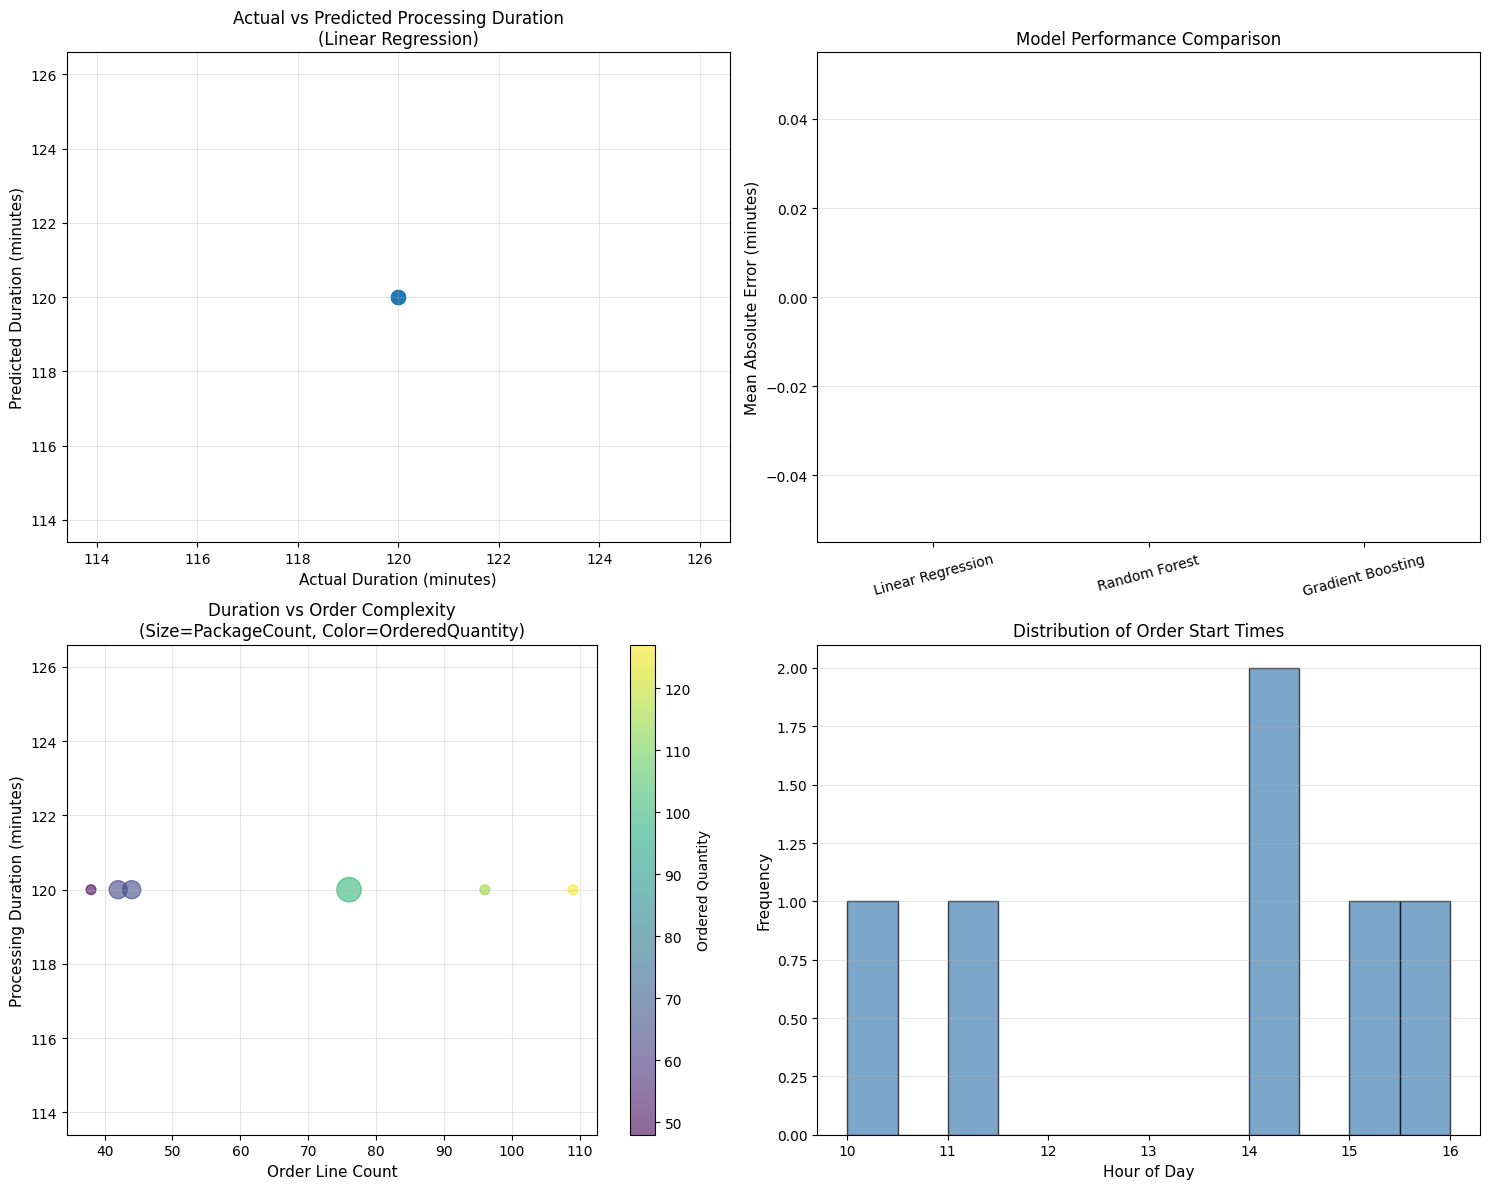

EXAMPLE: Predicting for a New Order

New Order Prediction:
  Start Time:              2026-02-07 09:00:00
  Predicted Duration:      120.00 minutes
  Predicted Dispatch Time: 2026-02-07 11:00:00
  Model Used:              Linear Regression


NOTE: With only 6 training samples, these predictions are for demonstration.
For production use, collect at least 100-1000 historical orders for reliable predictions.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Your data
data_str = '''Id,Status,StartDateTime,DispatchDateTime,Description,PackedQuantity,OrderedQuantity,ShortenedQuantity,OrderlineCount,PackageCount,Version
6220A6103ADFBE45BB6AD7B9068632EE,2,2/2/2026 11:27:00.0000000 AM,2/2/2026 1:27:00.0000000 PM,363600001548092142,0,48,48,38,0,3
013C4F65347C64498B07750F81300CC6,3,2/2/2026 2:12:00.0000000 PM,2/2/2026 4:12:00.0000000 PM,581100001548092157,0,115,0,96,0,2
FC5A488305177B45B553DCD271B47682,3,2/2/2026 2:15:00.0000000 PM,2/2/2026 4:15:00.0000000 PM,583900001548092160,0,127,0,109,0,2
48E5D07D19B50F48B6C143C097291883,2,2/2/2026 10:15:00.0000000 AM,2/2/2026 12:15:00.0000000 PM,301500001548092081,98,100,2,76,13,16
4ECECC7E4A9CD244BEBCCA80B7773DAC,2,2/2/2026 4:30:00.0000000 PM,2/2/2026 6:30:00.0000000 PM,304600001548092094,64,64,0,42,6,9
805D31201E47C74690F3A804A75B4A26,2,2/2/2026 3:36:00.0000000 PM,2/2/2026 5:36:00.0000000 PM,304700001548092095,65,65,0,44,6,9'''

# Load data
from io import StringIO
df = pd.read_csv(StringIO(data_str))

print("Original Data:")
print(df.head())
print("\n" + "="*80 + "\n")

# ==========================================
# FEATURE ENGINEERING FOR TIME PREDICTION
# ==========================================

def create_time_features(df):
    """Create features for time-based prediction"""
    df = df.copy()

    # Convert datetime columns
    df['StartDateTime'] = pd.to_datetime(df['StartDateTime'])
    df['DispatchDateTime'] = pd.to_datetime(df['DispatchDateTime'])

    # Target: Processing duration in minutes
    df['ProcessingDuration_Minutes'] = (df['DispatchDateTime'] - df['StartDateTime']).dt.total_seconds() / 60

    # Extract time-based features from StartDateTime
    df['Start_Hour'] = df['StartDateTime'].dt.hour
    df['Start_Minute'] = df['StartDateTime'].dt.minute
    df['Start_DayOfWeek'] = df['StartDateTime'].dt.dayofweek
    df['Start_IsWeekend'] = (df['Start_DayOfWeek'] >= 5).astype(int)

    # Time period features
    df['Start_TimeOfDay'] = pd.cut(df['Start_Hour'],
                                     bins=[0, 6, 12, 18, 24],
                                     labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    df['Start_TimeOfDay_Encoded'] = df['Start_TimeOfDay'].cat.codes

    # Order complexity features
    df['Items_Per_Orderline'] = df['OrderedQuantity'] / df['OrderlineCount'].replace(0, 1)
    df['Shortage_Rate'] = df['ShortenedQuantity'] / df['OrderedQuantity'].replace(0, 1)
    df['Completion_Rate'] = df['PackedQuantity'] / df['OrderedQuantity'].replace(0, 1)

    return df

df_processed = create_time_features(df)

print("Processed Data with Time Features:")
print(df_processed[['StartDateTime', 'DispatchDateTime', 'ProcessingDuration_Minutes',
                     'Start_Hour', 'OrderlineCount', 'OrderedQuantity']].head())
print("\n" + "="*80 + "\n")

# ==========================================
# MODEL 1: PREDICT PROCESSING DURATION
# ==========================================

print("MODEL 1: PREDICTING PROCESSING DURATION (Minutes)\n")

# Select features for prediction
feature_cols = [
    'Status', 'OrderedQuantity', 'ShortenedQuantity', 'OrderlineCount',
    'PackageCount', 'Version', 'Start_Hour', 'Start_Minute',
    'Start_DayOfWeek', 'Start_IsWeekend', 'Items_Per_Orderline',
    'Shortage_Rate'
]

X = df_processed[feature_cols].fillna(0)
y = df_processed['ProcessingDuration_Minutes']

print(f"Dataset size: {len(X)} samples")
print(f"Features used: {len(feature_cols)}")
print(f"\nTarget statistics (Processing Duration in minutes):")
print(f"  Mean: {y.mean():.2f} minutes")
print(f"  Std: {y.std():.2f} minutes")
print(f"  Min: {y.min():.2f} minutes")
print(f"  Max: {y.max():.2f} minutes")
print("\n" + "="*80 + "\n")

# Note: With only 6 samples, we'll use all data for training and demonstrate the approach
# In production, you'd need much more data for proper train/test split

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=3),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, random_state=42, max_depth=2)
}

results = {}

for name, model in models.items():
    # Train on all data (since dataset is small)
    model.fit(X, y)

    # Predict
    y_pred = model.predict(X)

    # Metrics
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"{name}:")
    print(f"  MAE:  {mae:.2f} minutes")
    print(f"  RMSE: {rmse:.2f} minutes")
    print(f"  R²:   {r2:.4f}")
    print()

print("="*80 + "\n")

# ==========================================
# MODEL 2: PREDICT DISPATCH TIME
# ==========================================

print("MODEL 2: PREDICTING DISPATCH TIME\n")

# For dispatch time prediction, we predict the duration and add it to start time
best_model_name = max(results, key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']

print(f"Using best model: {best_model_name}\n")

# Make predictions
df_processed['Predicted_Duration_Minutes'] = best_model.predict(X)
df_processed['Predicted_DispatchDateTime'] = df_processed['StartDateTime'] + \
    pd.to_timedelta(df_processed['Predicted_Duration_Minutes'], unit='m')

# Calculate prediction error
df_processed['Dispatch_Error_Minutes'] = (
    df_processed['DispatchDateTime'] - df_processed['Predicted_DispatchDateTime']
).dt.total_seconds() / 60

print("Dispatch Time Predictions:")
print(df_processed[['StartDateTime', 'DispatchDateTime', 'Predicted_DispatchDateTime',
                     'ProcessingDuration_Minutes', 'Predicted_Duration_Minutes',
                     'Dispatch_Error_Minutes']].to_string(index=False))
print("\n" + "="*80 + "\n")

# ==========================================
# FEATURE IMPORTANCE
# ==========================================

if hasattr(best_model, 'feature_importances_'):
    print("FEATURE IMPORTANCE (from best model):\n")
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(feature_importance.to_string(index=False))
    print("\n" + "="*80 + "\n")

# ==========================================
# VISUALIZATION
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted Duration
axes[0, 0].scatter(y, results[best_model_name]['predictions'], alpha=0.6, s=100)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Duration (minutes)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Duration (minutes)', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted Processing Duration\n({best_model_name})', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Model Comparison
model_names = list(results.keys())
maes = [results[m]['MAE'] for m in model_names]
axes[0, 1].bar(model_names, maes, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0, 1].set_ylabel('Mean Absolute Error (minutes)', fontsize=11)
axes[0, 1].set_title('Model Performance Comparison', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Processing Duration by Order Characteristics
scatter = axes[1, 0].scatter(df_processed['OrderlineCount'],
                             df_processed['ProcessingDuration_Minutes'],
                             c=df_processed['OrderedQuantity'],
                             s=df_processed['PackageCount']*20 + 50,
                             alpha=0.6, cmap='viridis')
axes[1, 0].set_xlabel('Order Line Count', fontsize=11)
axes[1, 0].set_ylabel('Processing Duration (minutes)', fontsize=11)
axes[1, 0].set_title('Duration vs Order Complexity\n(Size=PackageCount, Color=OrderedQuantity)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Ordered Quantity')

# Plot 4: Start Hour Distribution
axes[1, 1].hist(df_processed['Start_Hour'], bins=12, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Hour of Day', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Order Start Times', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('time_prediction_analysis.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'time_prediction_analysis.png'\n")
plt.show()

# ==========================================
# FUNCTION FOR NEW PREDICTIONS
# ==========================================

def predict_dispatch_time(start_datetime, status, ordered_qty, shortened_qty,
                         orderline_count, package_count, version):
    """
    Predict dispatch time for a new order

    Parameters:
    -----------
    start_datetime : datetime or str
        Start time of the order
    status : int
        Order status
    ordered_qty : int
        Ordered quantity
    shortened_qty : int
        Shortened quantity
    orderline_count : int
        Number of order lines
    package_count : int
        Number of packages
    version : int
        Version number

    Returns:
    --------
    dict : Predicted dispatch time and duration
    """

    # Convert to datetime if string
    if isinstance(start_datetime, str):
        start_datetime = pd.to_datetime(start_datetime)

    # Create feature dictionary
    features = {
        'Status': status,
        'OrderedQuantity': ordered_qty,
        'ShortenedQuantity': shortened_qty,
        'OrderlineCount': orderline_count,
        'PackageCount': package_count,
        'Version': version,
        'Start_Hour': start_datetime.hour,
        'Start_Minute': start_datetime.minute,
        'Start_DayOfWeek': start_datetime.dayofweek,
        'Start_IsWeekend': int(start_datetime.dayofweek >= 5),
        'Items_Per_Orderline': ordered_qty / max(orderline_count, 1),
        'Shortage_Rate': shortened_qty / max(ordered_qty, 1)
    }

    # Create DataFrame
    X_new = pd.DataFrame([features])[feature_cols]

    # Predict duration
    predicted_duration = best_model.predict(X_new)[0]

    # Calculate dispatch time
    predicted_dispatch = start_datetime + pd.Timedelta(minutes=predicted_duration)

    return {
        'start_time': start_datetime,
        'predicted_duration_minutes': predicted_duration,
        'predicted_dispatch_time': predicted_dispatch,
        'model_used': best_model_name
    }

# ==========================================
# EXAMPLE PREDICTION FOR NEW ORDER
# ==========================================

print("="*80)
print("EXAMPLE: Predicting for a New Order\n")

new_order = predict_dispatch_time(
    start_datetime='2/7/2026 9:00:00 AM',
    status=2,
    ordered_qty=75,
    shortened_qty=5,
    orderline_count=50,
    package_count=8,
    version=5
)

print(f"New Order Prediction:")
print(f"  Start Time:              {new_order['start_time']}")
print(f"  Predicted Duration:      {new_order['predicted_duration_minutes']:.2f} minutes")
print(f"  Predicted Dispatch Time: {new_order['predicted_dispatch_time']}")
print(f"  Model Used:              {new_order['model_used']}")

print("\n" + "="*80)
print("\nNOTE: With only 6 training samples, these predictions are for demonstration.")
print("For production use, collect at least 100-1000 historical orders for reliable predictions.")

QUANTITY-RELATED PREDICTIONS - MACHINE LEARNING MODELS

Original Data:
                              Id  Status                StartDateTime             DispatchDateTime        Description  PackedQuantity  OrderedQuantity  ShortenedQuantity  OrderlineCount  PackageCount  Version
6220A6103ADFBE45BB6AD7B9068632EE       2 2/2/2026 11:27:00.0000000 AM  2/2/2026 1:27:00.0000000 PM 363600001548092142               0               48                 48              38             0        3
013C4F65347C64498B07750F81300CC6       3  2/2/2026 2:12:00.0000000 PM  2/2/2026 4:12:00.0000000 PM 581100001548092157               0              115                  0              96             0        2
FC5A488305177B45B553DCD271B47682       3  2/2/2026 2:15:00.0000000 PM  2/2/2026 4:15:00.0000000 PM 583900001548092160               0              127                  0             109             0        2
48E5D07D19B50F48B6C143C097291883       2 2/2/2026 10:15:00.0000000 AM 2/2/2026 12:15:00.00000

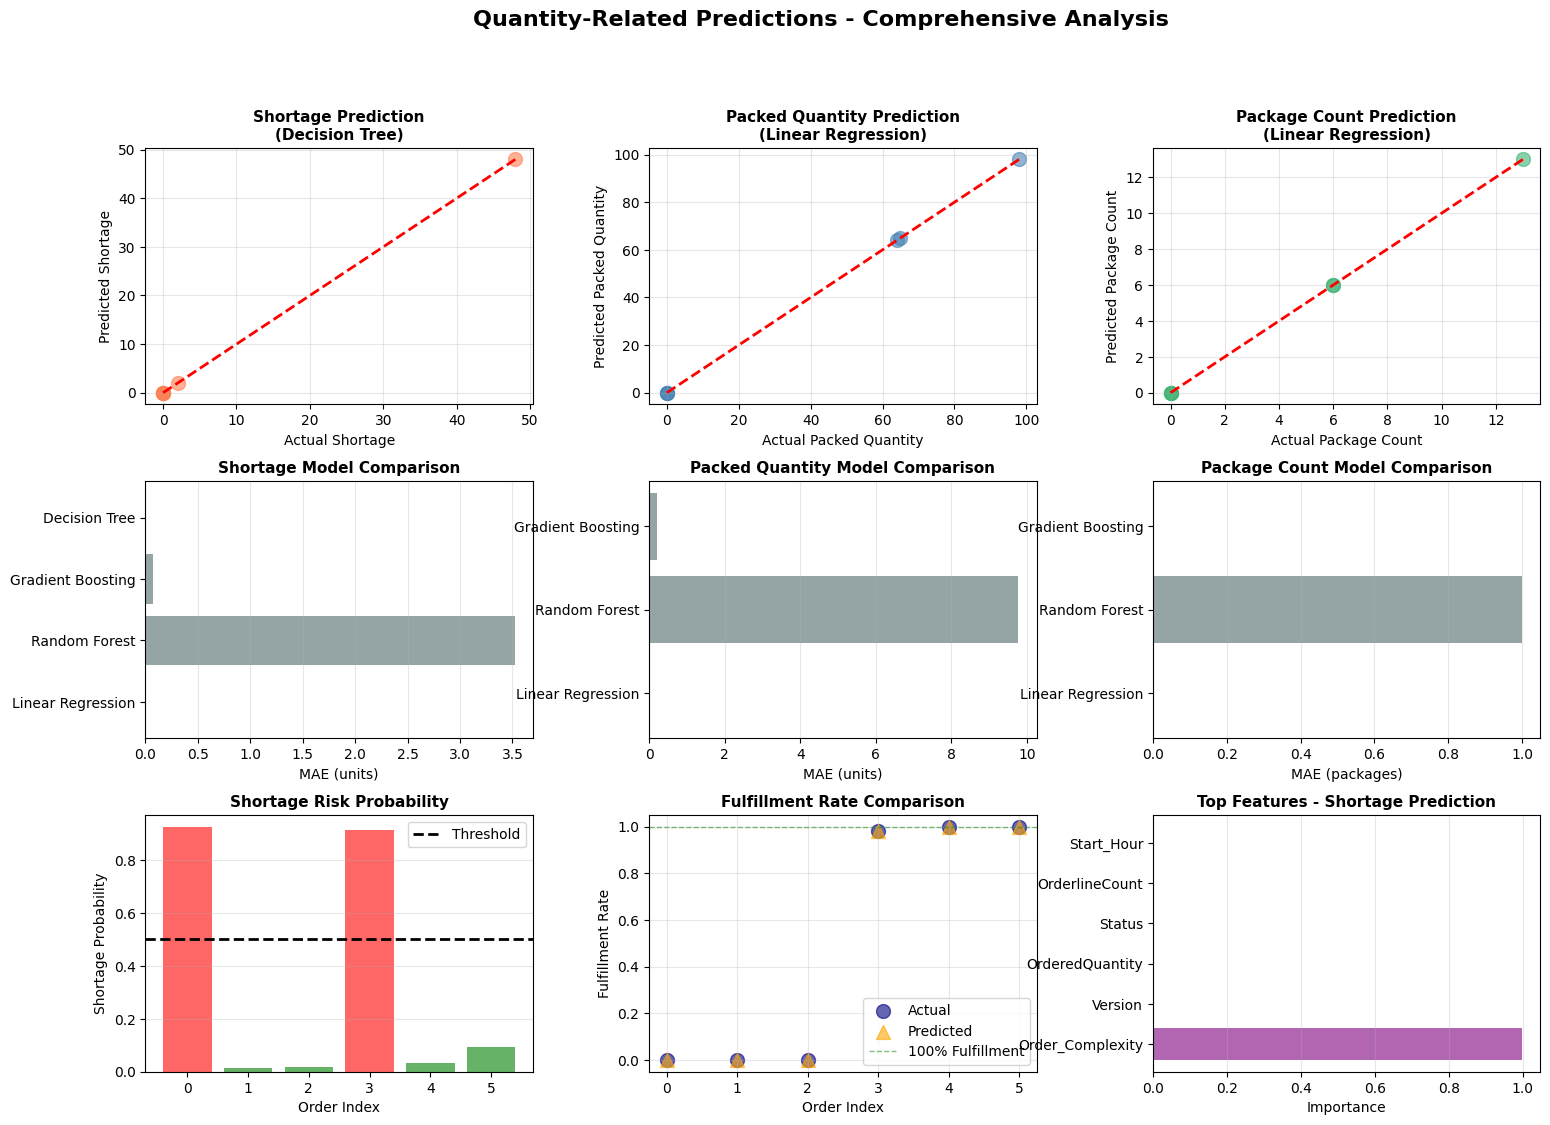

PREDICTION FUNCTIONS FOR NEW ORDERS

----------------------------------------------------------------------------------------------------
EXAMPLE 1: Small Order
----------------------------------------------------------------------------------------------------

Input:
  Ordered Quantity: 50

Predictions:
  Shortage Amount:        48.00 units
  Will Have Shortage:     True
  Shortage Probability:   85.91%
  Packed Quantity:        0.00 units
  Package Count:          0 packages
  Fulfillment Rate:       0.00%

----------------------------------------------------------------------------------------------------
EXAMPLE 2: Large Order
----------------------------------------------------------------------------------------------------

Input:
  Ordered Quantity: 200

Predictions:
  Shortage Amount:        0.00 units
  Will Have Shortage:     False
  Shortage Probability:   0.00%
  Packed Quantity:        0.00 units
  Package Count:          5 packages
  Fulfillment Rate:       0.00%


IMPO

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Your data
data_str = '''Id,Status,StartDateTime,DispatchDateTime,Description,PackedQuantity,OrderedQuantity,ShortenedQuantity,OrderlineCount,PackageCount,Version
6220A6103ADFBE45BB6AD7B9068632EE,2,2/2/2026 11:27:00.0000000 AM,2/2/2026 1:27:00.0000000 PM,363600001548092142,0,48,48,38,0,3
013C4F65347C64498B07750F81300CC6,3,2/2/2026 2:12:00.0000000 PM,2/2/2026 4:12:00.0000000 PM,581100001548092157,0,115,0,96,0,2
FC5A488305177B45B553DCD271B47682,3,2/2/2026 2:15:00.0000000 PM,2/2/2026 4:15:00.0000000 PM,583900001548092160,0,127,0,109,0,2
48E5D07D19B50F48B6C143C097291883,2,2/2/2026 10:15:00.0000000 AM,2/2/2026 12:15:00.0000000 PM,301500001548092081,98,100,2,76,13,16
4ECECC7E4A9CD244BEBCCA80B7773DAC,2,2/2/2026 4:30:00.0000000 PM,2/2/2026 6:30:00.0000000 PM,304600001548092094,64,64,0,42,6,9
805D31201E47C74690F3A804A75B4A26,2,2/2/2026 3:36:00.0000000 PM,2/2/2026 5:36:00.0000000 PM,304700001548092095,65,65,0,44,6,9'''

# Load data
df = pd.read_csv(StringIO(data_str))

print("="*100)
print("QUANTITY-RELATED PREDICTIONS - MACHINE LEARNING MODELS")
print("="*100)
print("\nOriginal Data:")
print(df.to_string(index=False))
print("\n" + "="*100 + "\n")

# ==========================================
# FEATURE ENGINEERING
# ==========================================

def create_quantity_features(df):
    """Create features for quantity predictions"""
    df = df.copy()

    # Convert datetime columns
    df['StartDateTime'] = pd.to_datetime(df['StartDateTime'])
    df['DispatchDateTime'] = pd.to_datetime(df['DispatchDateTime'])

    # Time-based features
    df['Start_Hour'] = df['StartDateTime'].dt.hour
    df['Start_DayOfWeek'] = df['StartDateTime'].dt.dayofweek
    df['ProcessingDuration_Minutes'] = (df['DispatchDateTime'] - df['StartDateTime']).dt.total_seconds() / 60

    # Quantity ratios and metrics
    df['Items_Per_Orderline'] = df['OrderedQuantity'] / df['OrderlineCount'].replace(0, 1)
    df['Shortage_Rate'] = df['ShortenedQuantity'] / df['OrderedQuantity'].replace(0, 1)
    df['Fulfillment_Rate'] = df['PackedQuantity'] / df['OrderedQuantity'].replace(0, 1)
    df['Packages_Per_Item'] = df['PackageCount'] / df['OrderedQuantity'].replace(0, 1)
    df['Items_Per_Package'] = df['OrderedQuantity'] / df['PackageCount'].replace(0, 1)

    # Order complexity
    df['Order_Complexity'] = df['OrderlineCount'] * df['Items_Per_Orderline']

    # Binary flags
    df['Has_Shortage'] = (df['ShortenedQuantity'] > 0).astype(int)
    df['Fully_Packed'] = (df['PackedQuantity'] == df['OrderedQuantity']).astype(int)
    df['Has_Packages'] = (df['PackageCount'] > 0).astype(int)

    # Replace inf values with 0
    df = df.replace([np.inf, -np.inf], 0)

    return df

df_processed = create_quantity_features(df)

print("Feature Engineering Complete!")
print("\nKey Metrics:")
print(df_processed[['OrderedQuantity', 'PackedQuantity', 'ShortenedQuantity',
                     'Shortage_Rate', 'Fulfillment_Rate', 'Items_Per_Orderline']].describe())
print("\n" + "="*100 + "\n")

# ==========================================
# PREDICTION 1: SHORTAGE QUANTITY
# ==========================================

print("PREDICTION 1: PREDICTING SHORTAGE QUANTITY")
print("-" * 100)

# Features for shortage prediction
shortage_features = [
    'Status', 'OrderedQuantity', 'OrderlineCount', 'Version',
    'Start_Hour', 'Start_DayOfWeek', 'Items_Per_Orderline', 'Order_Complexity'
]

X_shortage = df_processed[shortage_features].fillna(0)
y_shortage = df_processed['ShortenedQuantity']

print(f"\nDataset: {len(X_shortage)} samples")
print(f"Features: {shortage_features}")
print(f"\nTarget Statistics (ShortenedQuantity):")
print(f"  Mean: {y_shortage.mean():.2f}")
print(f"  Std:  {y_shortage.std():.2f}")
print(f"  Min:  {y_shortage.min():.0f}")
print(f"  Max:  {y_shortage.max():.0f}")

# Train models
shortage_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=2, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=3, random_state=42)
}

shortage_results = {}

print("\n" + "-" * 100)
print("Model Performance:")
print("-" * 100)

for name, model in shortage_models.items():
    model.fit(X_shortage, y_shortage)
    y_pred = model.predict(X_shortage)

    # Ensure non-negative predictions
    y_pred = np.maximum(y_pred, 0)

    mae = mean_absolute_error(y_shortage, y_pred)
    rmse = np.sqrt(mean_squared_error(y_shortage, y_pred))
    r2 = r2_score(y_shortage, y_pred)

    shortage_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f} units")
    print(f"  RMSE: {rmse:.2f} units")
    print(f"  R²:   {r2:.4f}")

print("\n" + "="*100 + "\n")

# ==========================================
# PREDICTION 2: PACKED QUANTITY
# ==========================================

print("PREDICTION 2: PREDICTING PACKED QUANTITY")
print("-" * 100)

# Features for packed quantity prediction
packed_features = [
    'Status', 'OrderedQuantity', 'ShortenedQuantity', 'OrderlineCount',
    'Version', 'Start_Hour', 'Items_Per_Orderline'
]

X_packed = df_processed[packed_features].fillna(0)
y_packed = df_processed['PackedQuantity']

print(f"\nDataset: {len(X_packed)} samples")
print(f"Features: {packed_features}")
print(f"\nTarget Statistics (PackedQuantity):")
print(f"  Mean: {y_packed.mean():.2f}")
print(f"  Std:  {y_packed.std():.2f}")
print(f"  Min:  {y_packed.min():.0f}")
print(f"  Max:  {y_packed.max():.0f}")

# Train models
packed_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=2, random_state=42)
}

packed_results = {}

print("\n" + "-" * 100)
print("Model Performance:")
print("-" * 100)

for name, model in packed_models.items():
    model.fit(X_packed, y_packed)
    y_pred = model.predict(X_packed)

    # Ensure predictions are within valid range
    y_pred = np.clip(y_pred, 0, df_processed['OrderedQuantity'].values)

    mae = mean_absolute_error(y_packed, y_pred)
    rmse = np.sqrt(mean_squared_error(y_packed, y_pred))
    r2 = r2_score(y_packed, y_pred)

    packed_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f} units")
    print(f"  RMSE: {rmse:.2f} units")
    print(f"  R²:   {r2:.4f}")

print("\n" + "="*100 + "\n")

# ==========================================
# PREDICTION 3: PACKAGE COUNT
# ==========================================

print("PREDICTION 3: PREDICTING PACKAGE COUNT")
print("-" * 100)

# Features for package count prediction
package_features = [
    'OrderedQuantity', 'OrderlineCount', 'PackedQuantity',
    'Items_Per_Orderline', 'Order_Complexity', 'Version'
]

X_package = df_processed[package_features].fillna(0)
y_package = df_processed['PackageCount']

print(f"\nDataset: {len(X_package)} samples")
print(f"Features: {package_features}")
print(f"\nTarget Statistics (PackageCount):")
print(f"  Mean: {y_package.mean():.2f}")
print(f"  Std:  {y_package.std():.2f}")
print(f"  Min:  {y_package.min():.0f}")
print(f"  Max:  {y_package.max():.0f}")

# Train models
package_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=2, random_state=42)
}

package_results = {}

print("\n" + "-" * 100)
print("Model Performance:")
print("-" * 100)

for name, model in package_models.items():
    model.fit(X_package, y_package)
    y_pred = model.predict(X_package)

    # Round to nearest integer and ensure non-negative
    y_pred = np.maximum(np.round(y_pred), 0)

    mae = mean_absolute_error(y_package, y_pred)
    rmse = np.sqrt(mean_squared_error(y_package, y_pred))
    r2 = r2_score(y_package, y_pred)

    package_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name}:")
    print(f"  MAE:  {mae:.2f} packages")
    print(f"  RMSE: {rmse:.2f} packages")
    print(f"  R²:   {r2:.4f}")

print("\n" + "="*100 + "\n")

# ==========================================
# PREDICTION 4: WILL ORDER HAVE SHORTAGE? (CLASSIFICATION)
# ==========================================

print("PREDICTION 4: SHORTAGE CLASSIFICATION (Will order have shortage?)")
print("-" * 100)

# Binary classification: will there be a shortage?
shortage_class_features = [
    'OrderedQuantity', 'OrderlineCount', 'Version',
    'Items_Per_Orderline', 'Order_Complexity', 'Start_Hour'
]

X_shortage_class = df_processed[shortage_class_features].fillna(0)
y_shortage_class = df_processed['Has_Shortage']

print(f"\nDataset: {len(X_shortage_class)} samples")
print(f"Features: {shortage_class_features}")
print(f"\nClass Distribution:")
print(f"  No Shortage (0): {(y_shortage_class == 0).sum()} orders ({(y_shortage_class == 0).sum()/len(y_shortage_class)*100:.1f}%)")
print(f"  Has Shortage (1): {(y_shortage_class == 1).sum()} orders ({(y_shortage_class == 1).sum()/len(y_shortage_class)*100:.1f}%)")

# Train classification models
shortage_class_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)
}

shortage_class_results = {}

print("\n" + "-" * 100)
print("Model Performance:")
print("-" * 100)

for name, model in shortage_class_models.items():
    model.fit(X_shortage_class, y_shortage_class)
    y_pred = model.predict(X_shortage_class)
    y_pred_proba = model.predict_proba(X_shortage_class)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_shortage_class, y_pred)

    shortage_class_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"\n  Classification Report:")
    print("  " + "\n  ".join(classification_report(y_shortage_class, y_pred,
                                                    target_names=['No Shortage', 'Has Shortage']).split('\n')))

print("\n" + "="*100 + "\n")

# ==========================================
# PREDICTION 5: FULFILLMENT RATE
# ==========================================

print("PREDICTION 5: PREDICTING FULFILLMENT RATE")
print("-" * 100)

# Fulfillment rate = PackedQuantity / OrderedQuantity
fulfillment_features = [
    'Status', 'OrderedQuantity', 'OrderlineCount', 'Version',
    'Items_Per_Orderline', 'Order_Complexity', 'Start_Hour'
]

X_fulfillment = df_processed[fulfillment_features].fillna(0)
y_fulfillment = df_processed['Fulfillment_Rate']

print(f"\nDataset: {len(X_fulfillment)} samples")
print(f"Features: {fulfillment_features}")
print(f"\nTarget Statistics (Fulfillment Rate):")
print(f"  Mean: {y_fulfillment.mean():.2%}")
print(f"  Std:  {y_fulfillment.std():.2%}")
print(f"  Min:  {y_fulfillment.min():.2%}")
print(f"  Max:  {y_fulfillment.max():.2%}")

# Train models
fulfillment_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=2, random_state=42)
}

fulfillment_results = {}

print("\n" + "-" * 100)
print("Model Performance:")
print("-" * 100)

for name, model in fulfillment_models.items():
    model.fit(X_fulfillment, y_fulfillment)
    y_pred = model.predict(X_fulfillment)

    # Ensure predictions are between 0 and 1
    y_pred = np.clip(y_pred, 0, 1)

    mae = mean_absolute_error(y_fulfillment, y_pred)
    rmse = np.sqrt(mean_squared_error(y_fulfillment, y_pred))
    r2 = r2_score(y_fulfillment, y_pred)

    fulfillment_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} ({mae*100:.2f}%)")
    print(f"  RMSE: {rmse:.4f} ({rmse*100:.2f}%)")
    print(f"  R²:   {r2:.4f}")

print("\n" + "="*100 + "\n")

# ==========================================
# CONSOLIDATED PREDICTIONS TABLE
# ==========================================

print("CONSOLIDATED PREDICTIONS - ALL MODELS")
print("="*100)

# Get best models based on lowest MAE or highest accuracy
best_shortage_model = min(shortage_results, key=lambda x: shortage_results[x]['MAE'])
best_packed_model = min(packed_results, key=lambda x: packed_results[x]['MAE'])
best_package_model = min(package_results, key=lambda x: package_results[x]['MAE'])
best_shortage_class_model = max(shortage_class_results, key=lambda x: shortage_class_results[x]['accuracy'])
best_fulfillment_model = min(fulfillment_results, key=lambda x: fulfillment_results[x]['MAE'])

# Create predictions dataframe
predictions_df = df_processed[['Id', 'OrderedQuantity', 'PackedQuantity', 'ShortenedQuantity',
                                 'PackageCount', 'Fulfillment_Rate']].copy()

predictions_df['Predicted_Shortage'] = shortage_results[best_shortage_model]['predictions']
predictions_df['Predicted_Packed'] = packed_results[best_packed_model]['predictions']
predictions_df['Predicted_Packages'] = package_results[best_package_model]['predictions']
predictions_df['Predicted_Will_Shortage'] = shortage_class_results[best_shortage_class_model]['predictions']
predictions_df['Shortage_Probability'] = shortage_class_results[best_shortage_class_model]['probabilities']
predictions_df['Predicted_Fulfillment_Rate'] = fulfillment_results[best_fulfillment_model]['predictions']

print("\nPredictions Table:")
print(predictions_df.to_string(index=False))

print("\n" + "="*100 + "\n")

# ==========================================
# FEATURE IMPORTANCE
# ==========================================

print("FEATURE IMPORTANCE ANALYSIS")
print("="*100)

def plot_feature_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"\n{title}:")
        print(importance_df.to_string(index=False))
        return importance_df
    return None

# Shortage prediction importance
shortage_imp = plot_feature_importance(
    shortage_results[best_shortage_model]['model'],
    shortage_features,
    f"Shortage Prediction ({best_shortage_model})"
)

# Package count importance
package_imp = plot_feature_importance(
    package_results[best_package_model]['model'],
    package_features,
    f"Package Count Prediction ({best_package_model})"
)

print("\n" + "="*100 + "\n")

# ==========================================
# VISUALIZATIONS
# ==========================================

fig = plt.figure(figsize=(18, 12))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Shortage Prediction - Actual vs Predicted
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_shortage, shortage_results[best_shortage_model]['predictions'],
            alpha=0.6, s=100, color='coral')
max_val = max(y_shortage.max(), shortage_results[best_shortage_model]['predictions'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2)
ax1.set_xlabel('Actual Shortage', fontsize=10)
ax1.set_ylabel('Predicted Shortage', fontsize=10)
ax1.set_title(f'Shortage Prediction\n({best_shortage_model})', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Packed Quantity - Actual vs Predicted
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_packed, packed_results[best_packed_model]['predictions'],
            alpha=0.6, s=100, color='steelblue')
max_val = max(y_packed.max(), packed_results[best_packed_model]['predictions'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', lw=2)
ax2.set_xlabel('Actual Packed Quantity', fontsize=10)
ax2.set_ylabel('Predicted Packed Quantity', fontsize=10)
ax2.set_title(f'Packed Quantity Prediction\n({best_packed_model})', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Package Count - Actual vs Predicted
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_package, package_results[best_package_model]['predictions'],
            alpha=0.6, s=100, color='mediumseagreen')
max_val = max(y_package.max(), package_results[best_package_model]['predictions'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2)
ax3.set_xlabel('Actual Package Count', fontsize=10)
ax3.set_ylabel('Predicted Package Count', fontsize=10)
ax3.set_title(f'Package Count Prediction\n({best_package_model})', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Model Comparison - Shortage Prediction
ax4 = fig.add_subplot(gs[1, 0])
models = list(shortage_results.keys())
maes = [shortage_results[m]['MAE'] for m in models]
colors = ['#2ecc71' if m == best_shortage_model else '#95a5a6' for m in models]
ax4.barh(models, maes, color=colors)
ax4.set_xlabel('MAE (units)', fontsize=10)
ax4.set_title('Shortage Model Comparison', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Model Comparison - Packed Quantity
ax5 = fig.add_subplot(gs[1, 1])
models = list(packed_results.keys())
maes = [packed_results[m]['MAE'] for m in models]
colors = ['#3498db' if m == best_packed_model else '#95a5a6' for m in models]
ax5.barh(models, maes, color=colors)
ax5.set_xlabel('MAE (units)', fontsize=10)
ax5.set_title('Packed Quantity Model Comparison', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# Plot 6: Model Comparison - Package Count
ax6 = fig.add_subplot(gs[1, 2])
models = list(package_results.keys())
maes = [package_results[m]['MAE'] for m in models]
colors = ['#e74c3c' if m == best_package_model else '#95a5a6' for m in models]
ax6.barh(models, maes, color=colors)
ax6.set_xlabel('MAE (packages)', fontsize=10)
ax6.set_title('Package Count Model Comparison', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='x')

# Plot 7: Shortage Classification Probability
ax7 = fig.add_subplot(gs[2, 0])
probs = shortage_class_results[best_shortage_class_model]['probabilities']
colors_prob = ['red' if p > 0.5 else 'green' for p in probs]
ax7.bar(range(len(probs)), probs, color=colors_prob, alpha=0.6)
ax7.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
ax7.set_xlabel('Order Index', fontsize=10)
ax7.set_ylabel('Shortage Probability', fontsize=10)
ax7.set_title('Shortage Risk Probability', fontsize=11, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Fulfillment Rate Distribution
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(range(len(y_fulfillment)), y_fulfillment, label='Actual',
            s=100, alpha=0.6, color='navy')
ax8.scatter(range(len(y_fulfillment)), fulfillment_results[best_fulfillment_model]['predictions'],
            label='Predicted', s=100, alpha=0.6, color='orange', marker='^')
ax8.axhline(y=1.0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='100% Fulfillment')
ax8.set_xlabel('Order Index', fontsize=10)
ax8.set_ylabel('Fulfillment Rate', fontsize=10)
ax8.set_title('Fulfillment Rate Comparison', fontsize=11, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Plot 9: Feature Importance (if available)
ax9 = fig.add_subplot(gs[2, 2])
if shortage_imp is not None:
    top_features = shortage_imp.head(6)
    ax9.barh(top_features['Feature'], top_features['Importance'], color='purple', alpha=0.6)
    ax9.set_xlabel('Importance', fontsize=10)
    ax9.set_title('Top Features - Shortage Prediction', fontsize=11, fontweight='bold')
    ax9.grid(True, alpha=0.3, axis='x')
else:
    ax9.text(0.5, 0.5, 'Feature importance\nnot available',
             ha='center', va='center', fontsize=12)
    ax9.axis('off')

plt.suptitle('Quantity-Related Predictions - Comprehensive Analysis',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('quantity_predictions_analysis.png', dpi=300, bbox_inches='tight')
print("Visualizations saved as 'quantity_predictions_analysis.png'\n")
plt.show()

# ==========================================
# PREDICTION FUNCTIONS FOR NEW ORDERS
# ==========================================

print("="*100)
print("PREDICTION FUNCTIONS FOR NEW ORDERS")
print("="*100)

def predict_quantities(ordered_qty, orderline_count, status=2, version=1,
                       start_hour=10, packed_qty=None):
    """
    Predict all quantity-related metrics for a new order

    Parameters:
    -----------
    ordered_qty : int
        Ordered quantity
    orderline_count : int
        Number of order lines
    status : int
        Order status (default: 2)
    version : int
        Version number (default: 1)
    start_hour : int
        Hour of day order started (default: 10)
    packed_qty : int, optional
        Packed quantity if known (for package prediction)

    Returns:
    --------
    dict : All quantity predictions
    """

    # Calculate derived features
    items_per_orderline = ordered_qty / max(orderline_count, 1)
    order_complexity = orderline_count * items_per_orderline
    start_dayofweek = 0  # Monday default

    # Shortage prediction
    X_shortage_new = pd.DataFrame([{
        'Status': status,
        'OrderedQuantity': ordered_qty,
        'OrderlineCount': orderline_count,
        'Version': version,
        'Start_Hour': start_hour,
        'Start_DayOfWeek': start_dayofweek,
        'Items_Per_Orderline': items_per_orderline,
        'Order_Complexity': order_complexity
    }])[shortage_features]

    predicted_shortage = max(0, shortage_results[best_shortage_model]['model'].predict(X_shortage_new)[0])

    # Shortage classification
    X_shortage_class_new = pd.DataFrame([{
        'OrderedQuantity': ordered_qty,
        'OrderlineCount': orderline_count,
        'Version': version,
        'Items_Per_Orderline': items_per_orderline,
        'Order_Complexity': order_complexity,
        'Start_Hour': start_hour
    }])[shortage_class_features]

    will_have_shortage = shortage_class_results[best_shortage_class_model]['model'].predict(X_shortage_class_new)[0]
    shortage_probability = shortage_class_results[best_shortage_class_model]['model'].predict_proba(X_shortage_class_new)[0][1]

    # Packed quantity prediction
    X_packed_new = pd.DataFrame([{
        'Status': status,
        'OrderedQuantity': ordered_qty,
        'ShortenedQuantity': predicted_shortage,
        'OrderlineCount': orderline_count,
        'Version': version,
        'Start_Hour': start_hour,
        'Items_Per_Orderline': items_per_orderline
    }])[packed_features]

    predicted_packed = np.clip(
        packed_results[best_packed_model]['model'].predict(X_packed_new)[0],
        0, ordered_qty
    )

    # Package count prediction
    if packed_qty is None:
        packed_qty = predicted_packed

    X_package_new = pd.DataFrame([{
        'OrderedQuantity': ordered_qty,
        'OrderlineCount': orderline_count,
        'PackedQuantity': packed_qty,
        'Items_Per_Orderline': items_per_orderline,
        'Order_Complexity': order_complexity,
        'Version': version
    }])[package_features]

    predicted_packages = max(0, round(package_results[best_package_model]['model'].predict(X_package_new)[0]))

    # Fulfillment rate prediction
    X_fulfillment_new = pd.DataFrame([{
        'Status': status,
        'OrderedQuantity': ordered_qty,
        'OrderlineCount': orderline_count,
        'Version': version,
        'Items_Per_Orderline': items_per_orderline,
        'Order_Complexity': order_complexity,
        'Start_Hour': start_hour
    }])[fulfillment_features]

    predicted_fulfillment = np.clip(
        fulfillment_results[best_fulfillment_model]['model'].predict(X_fulfillment_new)[0],
        0, 1
    )

    return {
        'ordered_quantity': ordered_qty,
        'predicted_shortage': round(predicted_shortage, 2),
        'will_have_shortage': bool(will_have_shortage),
        'shortage_probability': round(shortage_probability * 100, 2),
        'predicted_packed_quantity': round(predicted_packed, 2),
        'predicted_package_count': int(predicted_packages),
        'predicted_fulfillment_rate': round(predicted_fulfillment * 100, 2),
        'models_used': {
            'shortage': best_shortage_model,
            'packed': best_packed_model,
            'package': best_package_model,
            'classification': best_shortage_class_model,
            'fulfillment': best_fulfillment_model
        }
    }

# ==========================================
# EXAMPLE PREDICTIONS
# ==========================================

print("\n" + "-" * 100)
print("EXAMPLE 1: Small Order")
print("-" * 100)

example1 = predict_quantities(
    ordered_qty=50,
    orderline_count=35,
    status=2,
    version=2,
    start_hour=9
)

print(f"\nInput:")
print(f"  Ordered Quantity: {example1['ordered_quantity']}")
print(f"\nPredictions:")
print(f"  Shortage Amount:        {example1['predicted_shortage']:.2f} units")
print(f"  Will Have Shortage:     {example1['will_have_shortage']}")
print(f"  Shortage Probability:   {example1['shortage_probability']:.2f}%")
print(f"  Packed Quantity:        {example1['predicted_packed_quantity']:.2f} units")
print(f"  Package Count:          {example1['predicted_package_count']} packages")
print(f"  Fulfillment Rate:       {example1['predicted_fulfillment_rate']:.2f}%")

print("\n" + "-" * 100)
print("EXAMPLE 2: Large Order")
print("-" * 100)

example2 = predict_quantities(
    ordered_qty=200,
    orderline_count=150,
    status=2,
    version=5,
    start_hour=14
)

print(f"\nInput:")
print(f"  Ordered Quantity: {example2['ordered_quantity']}")
print(f"\nPredictions:")
print(f"  Shortage Amount:        {example2['predicted_shortage']:.2f} units")
print(f"  Will Have Shortage:     {example2['will_have_shortage']}")
print(f"  Shortage Probability:   {example2['shortage_probability']:.2f}%")
print(f"  Packed Quantity:        {example2['predicted_packed_quantity']:.2f} units")
print(f"  Package Count:          {example2['predicted_package_count']} packages")
print(f"  Fulfillment Rate:       {example2['predicted_fulfillment_rate']:.2f}%")

print("\n" + "="*100)
print("\nIMPORTANT NOTE:")
print("With only 6 training samples, these predictions are for DEMONSTRATION purposes.")
print("For reliable production predictions, collect at least 100-1000 historical orders.")
print("="*100)

In [2]:
import pandas as pd
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# ------------------------------------------------------------------
# 1) Load your raw string data as a DataFrame
# ------------------------------------------------------------------
data_str = """Id,Status,StartDateTime,DispatchDateTime,Description,PackedQuantity,OrderedQuantity,ShortenedQuantity,OrderlineCount,PackageCount,Version
6220A6103ADFBE45BB6AD7B9068632EE,2,2/2/2026 11:27:00.0000000 AM,2/2/2026 1:27:00.0000000 PM,363600001548092142,0,48,48,38,0,3
013C4F65347C64498B07750F81300CC6,3,2/2/2026 2:12:00.0000000 PM,2/2/2026 4:12:00.0000000 PM,581100001548092157,0,115,0,96,0,2
FC5A488305177B45B553DCD271B47682,3,2/2/2026 2:15:00.0000000 PM,2/2/2026 4:15:00.0000000 PM,583900001548092160,0,127,0,109,0,2
48E5D07D19B50F48B6C143C097291883,2,2/2/2026 10:15:00.0000000 AM,2/2/2026 12:15:00.0000000 PM,301500001548092081,98,100,2,76,13,16
4ECECC7E4A9CD244BEBCCA80B7773DAC,2,2/2/2026 4:30:00.0000000 PM,2/2/2026 6:30:00.0000000 PM,304600001548092094,64,64,0,42,6,9
805D31201E47C74690F3A804A75B4A26,2,2/2/2026 3:36:00.0000000 PM,2/2/2026 5:36:00.0000000 PM,304700001548092095,65,65,0,44,6,9
"""

df = pd.read_csv(StringIO(data_str))

# ------------------------------------------------------------------
# 2) Basic feature engineering for capacity/workload
# ------------------------------------------------------------------
# Convert timestamps
df["StartDateTime"] = pd.to_datetime(df["StartDateTime"])
df["DispatchDateTime"] = pd.to_datetime(df["DispatchDateTime"])

# Cycle time in minutes (proxy for processing effort)
df["cycle_time_min"] = (df["DispatchDateTime"] - df["StartDateTime"]).dt.total_seconds() / 60.0

# Time‑of‑day features
df["start_hour"] = df["StartDateTime"].dt.hour
df["start_weekday"] = df["StartDateTime"].dt.weekday  # 0=Mon

# Density/complexity features
df["qty_per_line"] = df["OrderedQuantity"] / df["OrderlineCount"].replace(0, 1)
df["packed_per_line"] = df["PackedQuantity"] / df["OrderlineCount"].replace(0, 1)

# ------------------------------------------------------------------
# 3) Define target and feature matrix
# ------------------------------------------------------------------
target_col = "PackageCount"
y = df[target_col]

feature_cols = [
    "Status",
    "PackedQuantity",
    "OrderedQuantity",
    "ShortenedQuantity",
    "OrderlineCount",
    "cycle_time_min",
    "start_hour",
    "start_weekday",
    "qty_per_line",
    "packed_per_line",
]
X = df[feature_cols]

# ------------------------------------------------------------------
# 4) Build train/test split (with more data this matters more)
# ------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Identify numeric vs categorical columns
numeric_features = [
    "PackedQuantity",
    "OrderedQuantity",
    "ShortenedQuantity",
    "OrderlineCount",
    "cycle_time_min",
    "start_hour",
    "start_weekday",
    "qty_per_line",
    "packed_per_line",
]
categorical_features = ["Status"]

# Preprocess: scale numeric if you want, one‑hot encode Status
numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# ------------------------------------------------------------------
# 5) Define and train a regression model for capacity
# ------------------------------------------------------------------
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model),
    ]
)

clf.fit(X_train, y_train)

# ------------------------------------------------------------------
# 6) Evaluate the model (capacity prediction quality)
# ------------------------------------------------------------------
y_pred = clf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE (packages): {mae:.3f}")
print(f"R2: {r2:.3f}")

# ------------------------------------------------------------------
# 7) Predict capacity/workload for new incoming lines
# ------------------------------------------------------------------
new_orders = pd.DataFrame(
    [
        {
            "Status": 2,
            "PackedQuantity": 70,
            "OrderedQuantity": 70,
            "ShortenedQuantity": 0,
            "OrderlineCount": 50,
            "cycle_time_min": 120.0,
            "start_hour": 15,
            "start_weekday": 1,
            "qty_per_line": 70 / 50,
            "packed_per_line": 70 / 50,
        }
    ]
)

new_package_preds = clf.predict(new_orders)
print("Predicted PackageCount for new order:", new_package_preds[0])


MAE (packages): 5.197
R2: 0.000
Predicted PackageCount for new order: 6.17
